## Move to correct directory

In [1]:
import os
current_file_dir = os.getcwd()
os.chdir("../../codes/")

# Usage example

Get possible models etc.

In [2]:
from src import strings_to_classes_mappings

print("Possible datasets:", list(strings_to_classes_mappings.datasets_mapping.keys()))
print("Possible models:", list(strings_to_classes_mappings.models_mapping.keys()))
print("Possible explanations:", list(strings_to_classes_mappings.explanations_mapping.keys()))

models_list = list(strings_to_classes_mappings.models_mapping.keys())

Possible datasets: ['imagenette2']
Possible models: ['ConvNeXtV2_Nano', 'DeiT_S', 'DeiT_T', 'DenseNet121', 'EfficientNet_B3', 'EfficientNet_B4', 'MobileNetV3', 'PyramidViT_V2_B2', 'Res2Net50', 'ResNet18', 'ResNet50', 'ResNeXt50', 'Swin_T', 'ViT_B_32']
Possible explanations: ['GradCAM', 'IntegratedGradients', 'KernelSHAP']


# Plot histograms

Loading explanations: 100%|██████████| 512/512 [00:07<00:00, 71.82it/s]


Loaded 512 common explanations for each model.


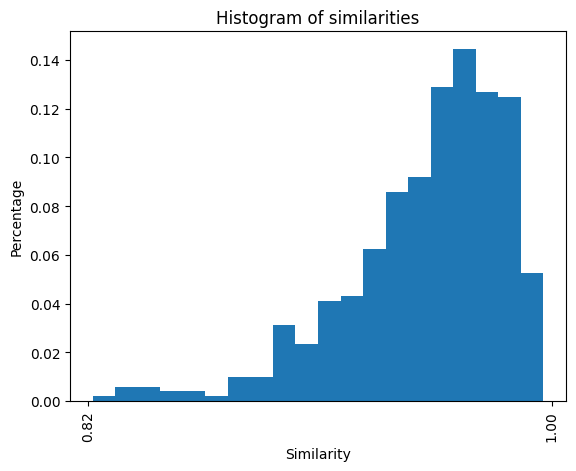

In [3]:
# for a pair of dicts with explanations of 2 models, compute similarity given some metric of every pair of images and return a histogram of similarities
def similarities_for_every_image(explanations1, explanations2, similarity_metric):
    similarities = []
    for e1, e2 in zip(explanations1, explanations2):
        similarities.append(similarity_metric(e1, e2))
    return np.array(similarities)

# plot histogram of similarities
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(similarities, bins=20):
    plt.hist(similarities, bins=bins, weights=np.ones(len(similarities)) / len(similarities))
    plt.xlabel('Similarity')
    plt.ylabel('Percentage')
    plt.title('Histogram of similarities')
    # plt.xticks([round(np.min(similarities),2), round(np.max(similarities),2)])
    plt.xticks(np.round([np.min(similarities), np.max(similarities)], 2))
    # add rotation to xticks
    plt.xticks(rotation=90)

    plt.show()

from src.compare_explanations import radial_basis_function
from src.load_explanations import load_explanations_of_many_models

explanations_many_models = load_explanations_of_many_models('imagenette2', models_list, 'GradCAM', root_explanations=current_file_dir)

explanations1 = explanations_many_models[0]['explanations']
explanations2 = explanations_many_models[1]['explanations']
similarities = similarities_for_every_image(explanations1, explanations2, radial_basis_function)
plot_histogram(similarities)

In [4]:
# cached_similarities = [[similarities for i in range(len(models_list))] for j in range(len(models_list))]

# create a giant grid of plots of size models x models, where each plot is a histogram of similarities between explanations of 2 models
def plot_all_similarities(explanations_many_models, similarity_metric):
    min_similarity = 100000
    max_similarity = -100000

    n_models = len(explanations_many_models)
    fig, axs = plt.subplots(n_models, n_models, figsize=(10, 10))
    for i in range(n_models):
        for j in range(n_models):
            if i == j:
                axs[i, j].axis('off')
                continue
            similarities = similarities_for_every_image(explanations_many_models[i]['explanations'], explanations_many_models[j]['explanations'], similarity_metric)
            # similarities = cached_similarities[i][j]
            min_similarity = min(min_similarity, min(similarities))
            max_similarity = max(max_similarity, max(similarities))
            axs[i, j].hist(similarities, bins=25, weights=np.ones(len(similarities)) / len(similarities))
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    
    for i in range(n_models):
        for j in range(n_models):
            axs[i, j].set_xlim(min_similarity, max_similarity)

    # set titles for each row and column, rotated 90 degrees
    for i, model in enumerate(models_list):
        axs[i, 0].set_ylabel(model, rotation=0, labelpad=70, fontsize=13)
        axs[n_models - 1, i].set_xlabel(model, rotation=90, fontsize=13)

    # title about the similarity metric
    explanation_name = explanations_many_models[0]['explanation_name']
    explanations_count = len(explanations_many_models[0]['explanations'])
    fig.suptitle(f'Histograms of explanation similarities\nExplanations: {explanation_name}, Metric: {similarity_metric.__name__}\nmin similarity: {min_similarity:.2f}, max similarity: {max_similarity:.2f}, {explanations_count} images', fontsize=20, y=0.99)
    plt.tight_layout()
    return fig

# Load explanations

In [5]:
from src.compare_explanations import radial_basis_function, cosine_similarity
from src.load_explanations import load_explanations_of_many_models

explanations_many_models = load_explanations_of_many_models('imagenette2', models_list, 'GradCAM', root_explanations=current_file_dir)

Loading explanations:   0%|          | 0/512 [00:00<?, ?it/s]

Loading explanations: 100%|██████████| 512/512 [00:00<00:00, 1188.70it/s]


Loaded 512 common explanations for each model.


In [6]:
explanations_many_models[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions'])

## Plot and save

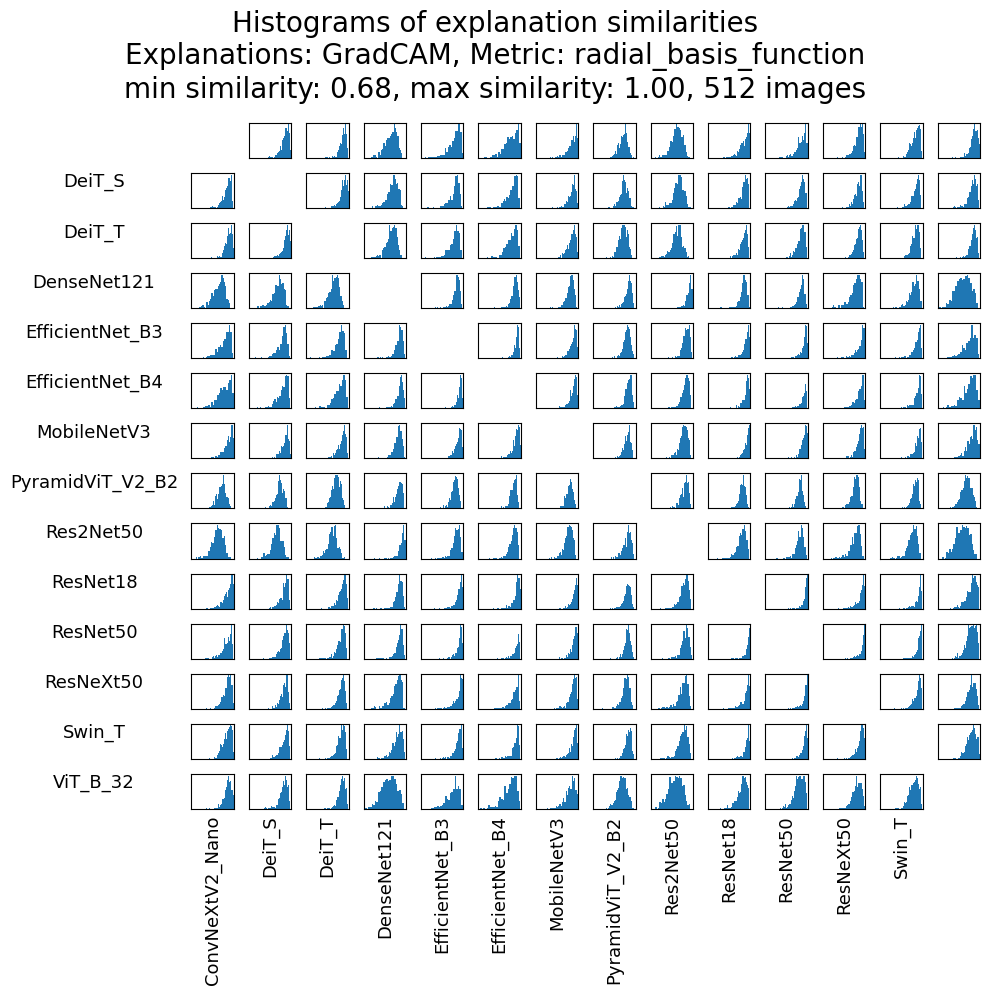

In [7]:
fig = plot_all_similarities(explanations_many_models, radial_basis_function)
plt.savefig(os.path.join(current_file_dir, "histograms_gradcam_rbf.png"))
plt.show()

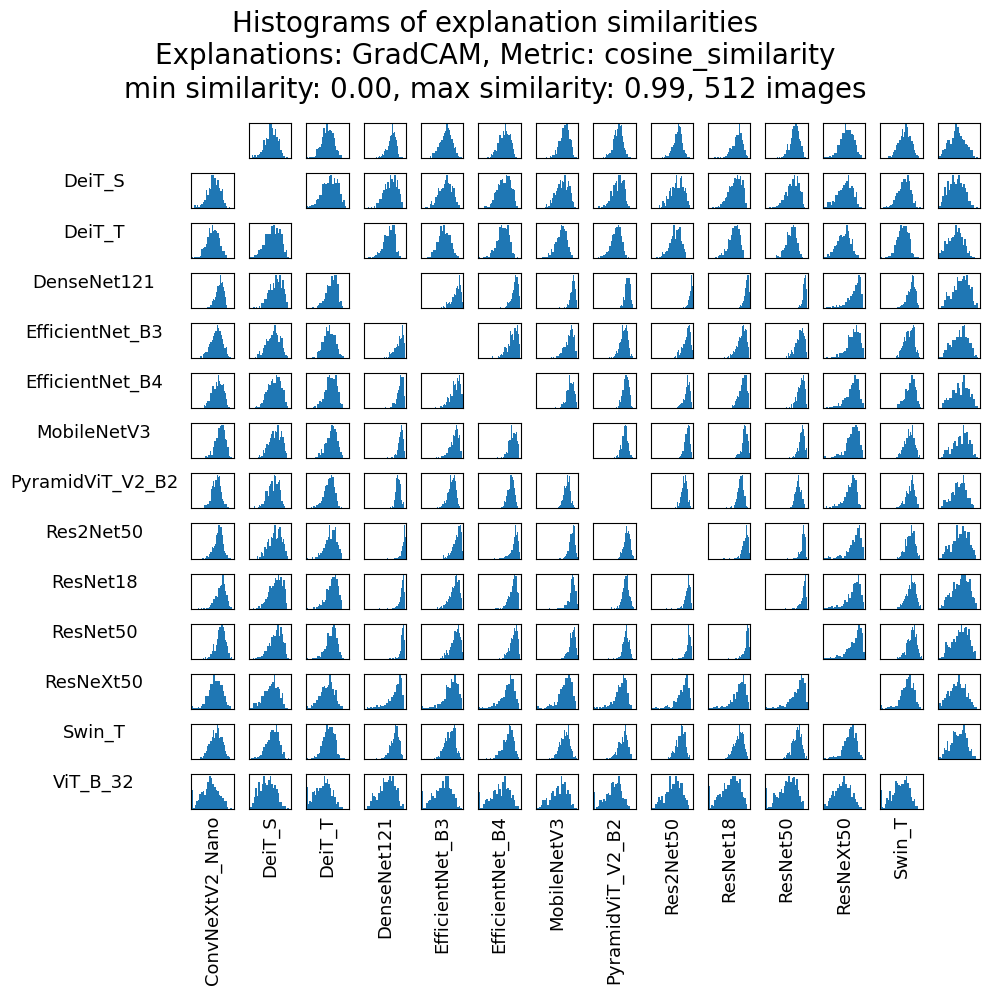

In [8]:
fig = plot_all_similarities(explanations_many_models, cosine_similarity)
plt.savefig(os.path.join(current_file_dir, "histograms_gradcam_cosine.png"))
plt.show()